In [1]:
%matplotlib inline
import numpy as np
from math import *
import matplotlib.pyplot as plt

## Problem 1

** Please see proof of Problem 1 (a), (b) on the main writeup report.**

## Problem 2
### (a)

In [2]:
# Pressure in the region S
def src_f(t):
    p0 = 10
    w = 100*pi
    return p0*sin(w*t)

# Determine if (x=j, y=k) is in S
def is_in_S(j, k):
    if j>=57 and j<=60 and k>=15 and k<=18:
        return True
    else:
        return False

In [3]:
# Read in the map of Pierce Hall
M, N = 100, 200
pierce_map = np.zeros((M, N))
lines = open('pierce.txt').readlines()
for i, line in enumerate(lines):
    pierce_map[i, :] = line.replace('\n', '').split(' ')

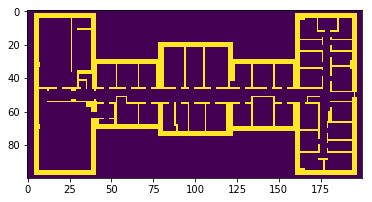

In [4]:
plt.imshow(pierce_map)

In [5]:
# Computer the big matrix for the pressure field
h = 36.6
c = 3.43e4
dt = h/(2*c)
snaps = 2000
nu = c*c*dt*dt/(h*h)

### Can directly load the pressure field np matrix using
`large_P = np.load('./pierce/pierce_t2000.npy')`

**It takes ~ 11 mins to run the following cell on my Mac...**

In [ ]:
P = np.zeros((M, N, snaps+1)) # The Pressure Field

# Initial condition t = 0
P[:, :, 0] = 0

# Initial condition t = 1 (t=0 is already satisfied)
for j in range(M):
    for k in range(N):
        if is_in_S(j, k):
            P[j, k, 1] = src_f(dt)

import time
start_time = time.time()

# Iteration <<< Reference: Lecture 15 Code Example Heat.py
for i in range(2, snaps+1):
    for j in range(M):
        for k in range(N):
            if pierce_map[j, k] == 1: # (j, k) is wall, skip
                continue
            
            if is_in_S(j, k): # (j,k) IN Region S
                P_jk = src_f((i-1)*dt)
                s1 = 2*src_f((i-1)*dt) - src_f((i-2)*dt) 
            else: # (j,k) NOT IN Region S
                P_jk = P[j, k, i-1]
                s1 = 2*P[j, k, i-1] - P[j, k, i-2]

            s2 = -4 * P_jk

            orth_neighbors = np.array([(j-1, k), (j+1, k), (j, k-1), (j, k+1)])
            for jn, kn in orth_neighbors:    
                if jn<0 or jn>=M or kn<0 or kn>=N: # (jn, kn) is NOT in map, s2 += 0, equivalent to skipping
                    continue
                else:
                    if pierce_map[jn, kn] == 1: # Is Wall
                        s2 += P_jk
                    elif is_in_S(jn, kn): # NOT WALL & In Region S
                        s2 += src_f((i-1)*dt)
                    else: # NOT WALL & NOT IN Region S
                        s2 += P[jn, kn, i-1]
            
            P[j, k, i] =  s1 + nu*s2 # Update P

print("--- Duration = %s seconds ---" % (time.time() - start_time))

np.save('./pierce/pierce_t2000', P)

In [6]:
large_P = np.load('./pierce/pierce_t2000.npy')

### (b)

In [7]:
# Provided code for custom plot
import sys

# Returns a scaled value of a function in the range 0 to 1, truncating it if necessary
def fscale(v,vmin,vsca):
    vs=(v-vmin)*vsca
    if vs<0: vs=0
    if vs>1: vs=1
    return vs

# Returns a red->white->blue color scheme
def palette1(v):
    v*=2
    if(v>1):
        v=2-v
        return (v,v,min(1,0.5+3*v))
    else:
        return (min(1,0.5+3*v),v,v)

# Outputs a 2D image from a field using the palette1 color scheme
# fn: the filename to save to
# p: the 2D field to plot
# wa: the matrix describing walls to overlay
# (vmin,vmax): the field range
# ups: the upsampling factor to use (so each field point is convert into an ups by ups square)
def plot1(fn,p,wa,vmin,vmax,ups):

    # Check matrix dimensions are the same
    (m,n)=p.shape
    if (m,n)!=wa.shape:
        print("Matrix dimension mismatch")

    # Set up output array and scaling constant
    o=np.zeros((m*ups,n*ups,3))
    vsca=1.0/(vmax-vmin)

    # Assemble the output array
    for i in range(m):
        iu=i*ups
        for j in range(n):
            ju=j*ups
            if wa[i,j]==1:
                o[iu:iu+ups,ju:ju+ups,0]=0
                o[iu:iu+ups,ju:ju+ups,1]=0
                o[iu:iu+ups,ju:ju+ups,2]=0
            else:
                (re,gr,bl)=palette1(fscale(p[i,j],vmin,vsca))
                o[iu:iu+ups,ju:ju+ups,0]=re
                o[iu:iu+ups,ju:ju+ups,1]=gr
                o[iu:iu+ups,ju:ju+ups,2]=bl
    
    # Save the image
    plt.imsave(fn,o)
    plt.imshow(o)

# Returns a black->red->yellow color scheme (matching Gnuplot's PM3D scheme)
def palette2(v):
    if v>0.5:
        vs=0
    else:
        vs=sin(2*pi*v)
    return (sqrt(v),v*v*v,vs)

# Outputs a 2D image from a field using the palette2 color scheme
# fn: the filename to save to
# p: the 2D field to plot
# wa: the matrix describing walls to overlay
# (vmin,vmax): the field range
# ups: the upsampling factor to use (so each field point is convert into an ups
#      by ups square)
def plot2(fn,p,wa,vmin,vmax,ups):
    
    # Check matrix dimensions are the same
    (m,n)=p.shape
    if (m,n)!=wa.shape:
        print("Matrix dimension mismatch")

    # Set up output array and scaling constant
    o=np.zeros((m*ups,n*ups,3))
    vsca=1.0/(vmax-vmin)

    # Assemble the output array
    for i in range(m):
        iu=i*ups
        for j in range(n):
            ju=j*ups
            if wa[i,j]==1:
                o[iu:iu+ups,ju:ju+ups,0]=1
                o[iu:iu+ups,ju:ju+ups,1]=1
                o[iu:iu+ups,ju:ju+ups,2]=1
            else:
                (re,gr,bl)=palette2(fscale(p[i,j],vmin,vsca))
                o[iu:iu+ups,ju:ju+ups,0]=re
                o[iu:iu+ups,ju:ju+ups,1]=gr
                o[iu:iu+ups,ju:ju+ups,2]=bl

    # Save the image
    plt.imsave(fn,o)
    plt.imshow(o)


In [8]:
P_last = large_P[:, :, -1]
p_min = np.min(P_last)
p_max = np.max(P_last)
print('The magitude of the P in the last iteration is {} ~ {}'.format(p_min, p_max))

The magitude of the P in the last iteration is -43.34730364254081 ~ 41.53652109925552


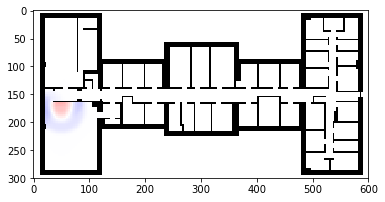

In [9]:
ts = [0.015, 0.105, 0.505, 1.005]

# Load in the wall matrix
wall = np.loadtxt("pierce.txt",dtype=np.int8)

# Plot t = 0.015
plot1("./pierce/t0.png", large_P[:, :, int(ts[0]/dt)], wall, -45, 45, 3)

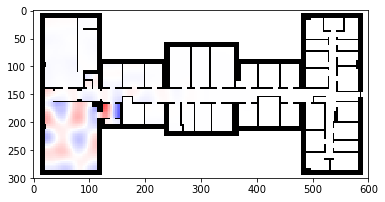

In [10]:
# Plot t = 0.105
plot1("./pierce/t1.png", large_P[:, :, int(ts[1]/dt)], wall, -45, 45, 3)

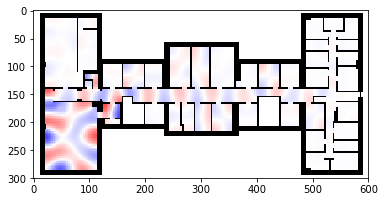

In [11]:
# Plot t = 0.505
plot1("./pierce/t2.png", large_P[:, :, int(ts[2]/dt)], wall, -45, 45, 3)

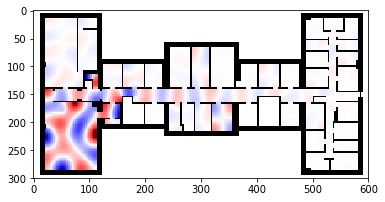

In [12]:
# Plot t = 1.005
plot1("./pierce/t3.png", large_P[:, :, int(ts[3]/dt)], wall, -45, 45, 3)

### (c)

In [13]:
P_C_t = large_P[35, 73, :]
P_G_t = large_P[61, 109, :]
P_M_t = large_P[91, 188, :]
t_C, t_G, t_M = -1, -1, -1

n_time_step = large_P.shape[-1]
for n in range(n_time_step):
    if t_C != -1 and t_G != -1 and t_M != -1:
        break
    if abs(P_C_t[n]) > 1e-3 and t_C == -1:
        t_C = n * dt
    if abs(P_G_t[n]) > 1e-3 and t_G == -1:
        t_G = n * dt
    if abs(P_M_t[n]) > 1e-3 and t_M == -1:
        t_M = n * dt

print('Time (sec) when the three people first hear the sound\n')
print('C: {} \nG: {} \nM: {}'.format(t_C, t_G, t_M))

Time (sec) when the three people first hear the sound

C: 0.07362682215743441 
G: 0.1088396501457726 
M: 0.2310174927113703


### (d)

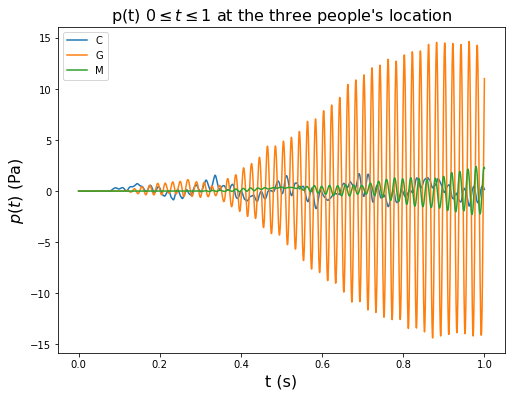

In [14]:
# Plot p(t) at the three people's location for 0 <= t <= 1
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
t_steps = int(1/dt) + 1
t_lin = np.linspace(0, 1, t_steps)
ax.plot(t_lin, P_C_t[:t_steps], label='C')
ax.plot(t_lin, P_G_t[:t_steps], label='G')
ax.plot(t_lin, P_M_t[:t_steps], label='M')
ax.set_xlabel('t (s)', fontsize=16)
ax.set_ylabel('$p(t)$ (Pa)', fontsize=16)
ax.set_title('p(t) $0 \leq t \leq 1$ at the three people\'s location', fontsize=16)
ax.legend()

## Problem 3
### (b)

In [15]:
n = 101
h = 2/(n-1)
b = 1/(h*h)

def get_F(U): # F(U)
    F = np.zeros((n-2,))
    F[0] = (U[1]-2*U[0])*b - exp(U[0])
    F[n-3] = (-2*U[n-3]+U[n-4])*b - exp(U[n-3])
    for i in range(1, n-3):
        F[i] = (U[i+1] - 2*U[i] + U[i-1])*b - exp(U[i])
    return F

def get_J(U): # Jacobian of F(U)
    A = np.zeros((n-2, n-2))
    A[0:n-3, 1:n-2] = b*np.eye(n-3)
    J = np.add(-2*b*np.eye(n-2), A)
    B = np.zeros((n-2, n-2))
    B[1:n-2, 0:n-3] = b*np.eye(n-3)
    J = np.add(J, B)
    
    for i in range(n-2):
        J[i,i] += -exp(U[i])
    return J

# Newton Roots Finding: F(U) = 0
U0 = np.zeros((n-2,))
F = get_F(U0)
J = get_J(U0)
delta_U = np.linalg.solve(J, -1*F)
U = U0
relative_step = 100
while relative_step > 1e-10:
    U = np.add(delta_U, U)
    F = get_F(U)
    J = get_J(U)
    delta_U = np.linalg.solve(J, -1*F)
    relative_step = np.linalg.norm(delta_U)/np.linalg.norm(U)


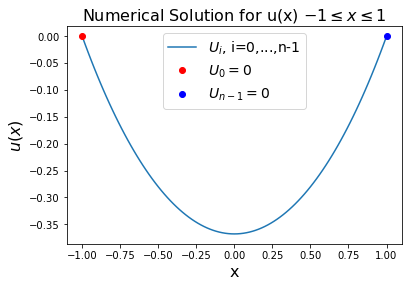

In [16]:
# Pad the approximate solution U with U0 & Un-1
U_all = np.zeros((n,))
U_all[0] = 0
U_all[-1] = 0
U_all[1:-1] = np.copy(U)

# Plot U
plt.plot(np.linspace(-1, 1, n), U_all, '-', label='$U_i$, i=0,...,n-1')

plt.plot(-1, 0, 'ro', label='$U_0 = 0$')
plt.plot(1, 0, 'bo', label='$U_{n-1} = 0$')

plt.legend(fontsize=14)
plt.title('Numerical Solution for u(x) $-1 \leq x \leq 1$', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('$u(x)$', fontsize=16)

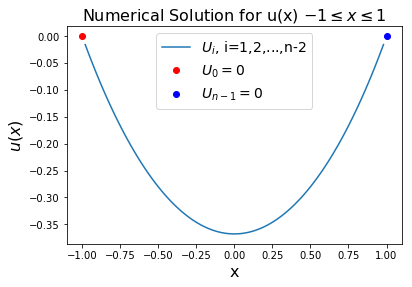

In [17]:
# Plot the approximate solution U
plt.plot(np.linspace(-1, 1, n)[1:-1], U, '-', label='$U_i$, i=1,2,...,n-2')

# Pad with U0 & Un-1
plt.plot(-1, 0, 'ro', label='$U_0 = 0$')
plt.plot(1, 0, 'bo', label='$U_{n-1} = 0$')

plt.legend(fontsize=14)
plt.title('Numerical Solution for u(x) $-1 \leq x \leq 1$', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('$u(x)$', fontsize=16)

In [18]:
print('Approximation to u(0) is {}, index={}'.format(U[int(1/h-1)], int(1/h-1)))

Approximation to u(0) is -0.36804821826994366, index=49
